In [66]:
import numpy as np, pylab,sys
import matplotlib.pyplot as plt
%matplotlib inline  

In [67]:
def get_stats(log_mass,conc, bins):
    median_conc = np.empty(len(bins)-1)
    quar1_conc = np.empty(len(bins)-1)
    quar2_conc = np.empty(len(bins)-1)

    for i in range(len(bins)-1):
        mass_index = np.where((log_mass>bins[i]) & (log_mass<bins[i+1]))
        conc_index = conc[mass_index]
        print np.size(mass_index)
        median_conc[i] = np.percentile(conc_index, 50)
        quar1_conc[i] = np.percentile(conc_index, 25)
        quar2_conc[i] = np.percentile(conc_index, 75)
    return median_conc,quar1_conc,quar2_conc

def enlarge_labels(ax,fsize):
    ticklabels_x = ax.get_xticklabels()
    ticklabels_y = ax.get_yticklabels()

    for label_x in ticklabels_x:
        label_x.set_fontsize(fsize)
        label_x.set_family('serif')
    for label_y in ticklabels_y:
        label_y.set_fontsize(fsize)
        label_y.set_family('serif')

In [90]:
density_filename = "../data/results/jc/MultiDark/Rvir_Mvir_fitparams_Multidark.dat"
velocity_filename = "../data/results/MDmini/velocity/results.csv"
mass_filename = "../data/results/MDmini/mass/results.csv"
centers = "../data/results/MDmini/centers.csv"

../data/results/MDmini/centers.csv


In [95]:
data_density = np.loadtxt(density_filename)
data_velocity = np.loadtxt(velocity_filename, delimiter=",")
data_mass = np.loadtxt(mass_filename, delimiter=",")
data_centers = np.loadtxt(centers, delimiter=",")

In [106]:
# mass here is the virial mass
mass_density = data_density[:,1]*1.0E10
conc_density = data_density[:,0]/data_density[:,2]
log_mass_density = np.log10(mass_density)

particle_mass = 8.721E9

mass_velocity = data_velocity[:,7]*particle_mass
conc_velocity = data_velocity[:,4]
log_mass_velocity = np.log10(mass_velocity)

mass_mass  = data_mass[:,8]*particle_mass
conc_mass = data_mass[:,4]
log_mass_mass = np.log10(mass_mass)

#center offset
delta_center = np.sqrt((data_centers[:,1] - data_centers[:,4])**2
                    + (data_centers[:,2] - data_centers[:,5])**2
                    + (data_centers[:,3] - data_centers[:,6])**2)
#delta_center = delta_center/data_velocity[:,6]

ValueError: operands could not be broadcast together with shapes (14124,) (14244,) 

(0.0, 50.0)

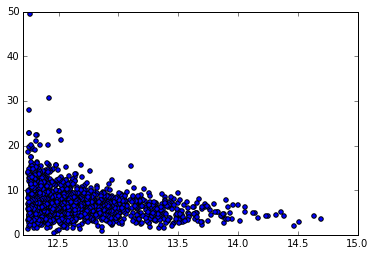

In [71]:
fig = plt.figure()
plt.scatter(np.log10(mass_density), conc_density)
plt.xlim([12.2,15.0])
plt.ylim([0.0,50.0])

In [72]:
n_bins = 7
log_mass_interval = np.linspace(12.25,14.5,n_bins)
mid_log_mass_interval = 0.5*(log_mass_interval[1:] + log_mass_interval[:-1])
mid_log_mass_interval =  log_mass_interval[:-1]

conc_median = np.ones((n_bins-1,3))
conc_up = np.ones((n_bins-1,3))
conc_down = np.ones((n_bins-1,3))

conc_median[:,0], conc_down[:,0], conc_up[:,0] = get_stats(log_mass_density,conc_density, log_mass_interval)
conc_median[:,1], conc_down[:,1], conc_up[:,1] = get_stats(log_mass_velocity,conc_velocity, log_mass_interval)
conc_median[:,2], conc_down[:,2], conc_up[:,2] = get_stats(log_mass_mass,conc_mass, log_mass_interval)


977
437
161
78
26
8
977
437
161
78
26
8
977
437
161
78
26
8


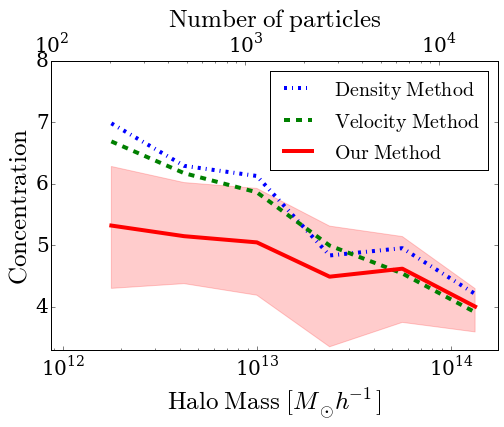

In [73]:
fig = plt.figure(figsize=(8.0,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

estilos = ['-.', '--', '-']
colores = ['blue', 'green', 'red']
origen = ['$\mathrm{Density\ Method}$','$\mathrm{Velocity\ Method}$','$\mathrm{Our\ Method}$']
for i in range(3):
    ax.plot(10**mid_log_mass_interval,conc_median[:,i],colores[i],lw=4,linestyle=estilos[i], label=origen[i])

ax.fill_between(10**mid_log_mass_interval,conc_down[:,2], conc_up[:,2], color=colores[2], alpha=0.2)
    
ax.legend(loc=1, borderaxespad=0.5, prop={'size':20})
plt.xlim([1E2*particle_mass,2E4*particle_mass])
plt.ylim([3.5,8])
#ax.plot(mid_log_mass_interval-np.log10(particle_mass),conc_median[:,0], lw=0)

ax2 = ax.twiny()
enlarge_labels(ax2,20)

plt.subplots_adjust(bottom=0.18, top=0.85)
ax2.set_xscale('log')
ax2.set_xlim([1E2,2E4])
ax2.set_ylim([3.3,8.0])

ax2.set_xlabel('$\mathrm{Number\ of\ particles}$',fontsize=25)
ax.set_xscale('log')
ax.set_xlabel('$\mathrm{Halo\ Mass}\ [M_{\odot} h^{-1}]$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration}$',fontsize=25)
plt.savefig("concentration.pdf")

In [99]:
index_greater = np.where(log_mass_density>12.5)
index_greater = index_greater[0]
print np.size(index_greater)
sort_index = np.argsort(log_mass_density[index_greater])
conc_density_sorted = conc_density[index_greater[sort_index]]

delta_center_sorted = delta_center[index_greater[sort_index]]

index_greater = np.where(log_mass_velocity>12.5)
index_greater = index_greater[0]
print np.size(index_greater)
sort_index = np.argsort(log_mass_velocity[index_greater])
conc_velocity_sorted = conc_velocity[index_greater[sort_index]]

index_greater = np.where(log_mass_mass>12.5)
index_greater = index_greater[0]
print np.size(index_greater)
sort_index = np.argsort(log_mass_mass[index_greater])
conc_mass_sorted = conc_mass[index_greater[sort_index]]

967
967
967


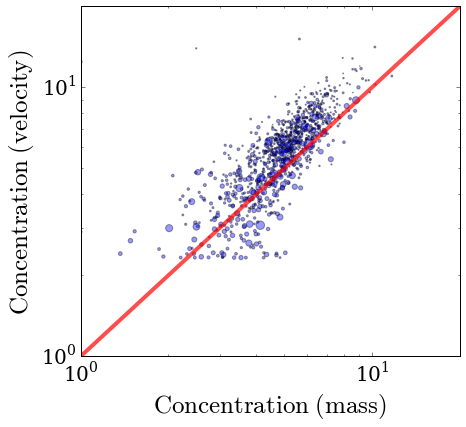

In [104]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,100, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.scatter(conc_mass_sorted, conc_velocity_sorted, s=delta_center_sorted*100, alpha=0.4)

plt.xlim([1,20])
plt.ylim([1,20])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (mass)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (velocity)}$',fontsize=25)
plt.savefig("conc_mass_vel.pdf")

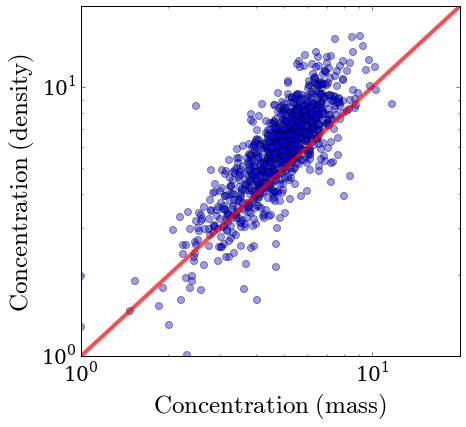

In [76]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,100, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.scatter(conc_mass_sorted, conc_density_sorted, s=50, alpha=0.4)

plt.xlim([1,20])
plt.ylim([1,20])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (mass)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (density)}$',fontsize=25)
plt.savefig("conc_mass_dens.pdf")

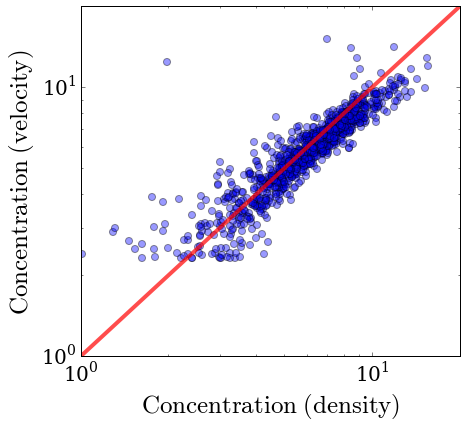

In [77]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,100, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.scatter(conc_density_sorted, conc_velocity_sorted, s=50, alpha=0.4)

plt.xlim([1,20])
plt.ylim([1,20])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (density)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (velocity)}$',fontsize=25)
plt.savefig("conc_dens_vel.pdf")

In [78]:
#now comes the comparison of the mock halos

In [79]:
density_filename = "../data/test/mock_100/newDensity/table.csv"
velocity_filename = "../data/test/mock_100/velocity/table.csv"
mass_filename = "../data/test/mock_100/newMass/table.csv"

In [80]:
density_data = np.loadtxt(density_filename, delimiter=',')
velocity_data = np.loadtxt(velocity_filename, delimiter=',')
mass_data = np.loadtxt(mass_filename, delimiter=',')

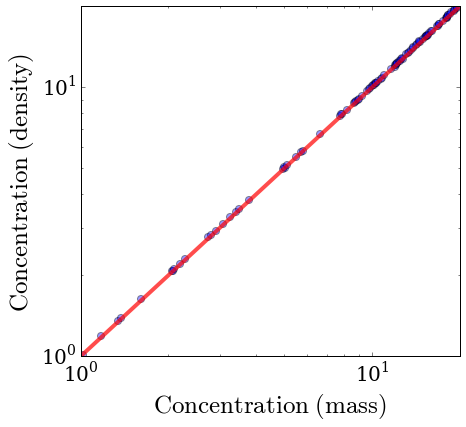

In [84]:

fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,25, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.scatter(mass_data[:,2], density_data[:,2],s=50, alpha=0.4)


plt.xlim([1,20])
plt.ylim([1,20])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (mass)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (density)}$',fontsize=25)
plt.savefig("conc_mass_dens_intrinsic.pdf")

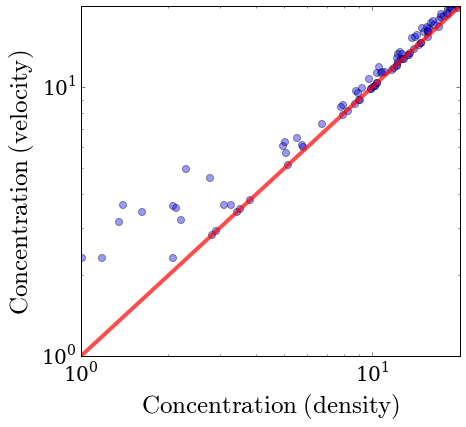

In [85]:

fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,25, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.scatter(density_data[:,2], velocity_data[:,2],s=50, alpha=0.4)


plt.xlim([1,20])
plt.ylim([1,20])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (density)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (velocity)}$',fontsize=25)
plt.savefig("conc_dens_vel_intrinsic.pdf")

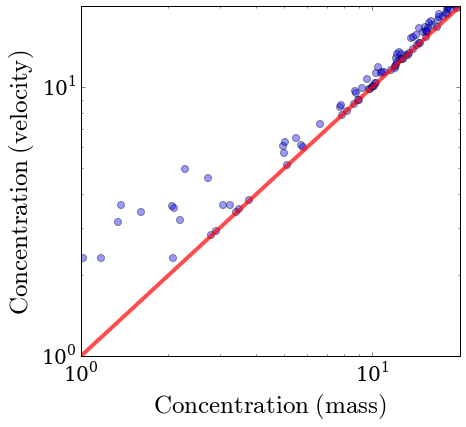

In [88]:

fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

x = np.linspace(0.0,25, 100)
plt.plot(x,x, color='red', linewidth=4, alpha=0.7)
plt.scatter(mass_data[:,2], velocity_data[:,2],s=50, alpha=0.4)


plt.xlim([1,20])
plt.ylim([1,20])

plt.subplots_adjust(bottom=0.18, top=0.99, left=0.18, right=0.99)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Concentration\ (mass)}$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration\ (velocity)}$',fontsize=25)
plt.savefig("conc_mass_vel_intrinsic.pdf")